# Classification with complex features

The code below uses more complex feature engineering to revisit the classification task performed in chapter 5. Specifically, it replaces unigram token counts with counts of entities and keyphrases as explored in chapter 7.

Note that we've worked around some problems with the `FeatureUnion` class by performing the same task piecemeal. Outputs are unchanged either way.

## Imports and setup

In [1]:
%matplotlib inline
# Imports and variables
import en_core_web_sm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import spacy
import sys
import time
import unicodedata
import warnings

from itertools import groupby
from nltk.chunk import RegexpParser, tree2conlltags
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from unicodedata import category as unicat

# Import our corpus readers
sys.path.append(os.path.join('..', 'libraries'))
import TMN

# File locations
pkl_dir = os.path.join('..', 'data', 'pickled')
wordlist_dir = os.path.join('..', 'data', 'wordlists')

# Plotting settings
plt.rcParams['figure.figsize'] = [12, 8]

## Classes and functions

In [2]:
# Classification system
def identity(words):
    return words

class EntityExtractor(BaseEstimator, TransformerMixin):
        
    def get_entities(self, document):
        nlp = en_core_web_sm.load()
        entities = []
        for paragraph in document:
            for sentence in paragraph:
                doc = nlp(' '.join(word for word, tag in sentence))
                for ent in doc.ents:
                    entities.append(ent.text)

        return entities

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            if len(document)==1:
                document = document[0]
            entities = self.get_entities(document)
            print(f'Entities: {len(entities)}. {entities[:3]}')
            yield entities
            
            
GRAMMAR = r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}' # CFG for KeyphraseExtractor class
class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Wraps a PickledCorpusReader consisting of pos-tagged documents.
    """
    def __init__(self, grammar=GRAMMAR):
        self.grammar = GRAMMAR
        self.chunker = RegexpParser(self.grammar)

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(char).startswith('P') for char in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    def extract_keyphrases(self, document):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Yields extracted phrases.
        """
        for sents in document:
            for sent in sents:
                sent = self.normalize(sent)
                if not sent: continue
                chunks = tree2conlltags(self.chunker.parse(sent))
                phrases = [
                    " ".join(word for word, pos, chunk in group).lower()
                    for key, group in groupby(
                        chunks, lambda term: term[-1] != 'O'
                    ) if key
                ]
                for phrase in phrases:
                    yield phrase

    def fit(self, documents, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            if len(document)==1:
                document = document[0]
            keyphrases = list(self.extract_keyphrases(document))
            print(f'Keyphrases: {len(keyphrases)}. {keyphrases[:3]}')
            yield keyphrases

## Feature extraction

In [15]:
# Corpus and labels
corpus = TMN.PickledCorpusReader(pkl_dir)
docs = [doc for doc in corpus.docs()]
labels = [categories for fileid in corpus.fileids() for categories in corpus.categories(fileids=fileid) if categories in ('A', 'B')]

In [22]:
%%time
keyphrase_pipeline = Pipeline([
    ('keyphrase_extractor', KeyphraseExtractor()),
    ('keyphrase_vect', TfidfVectorizer(
        tokenizer=identity, 
        preprocessor=None, 
        lowercase=False,
        min_df=2, 
        max_df=0.7
    ))
])

keyphrase_features = keyphrase_pipeline.fit_transform(docs, labels)
print(keyphrase_features.shape)

Keyphrases: 34267. ['chapter', 'playing pilgrims', 'christmas']
Keyphrases: 15198. ['introduction', 'last summer', 'plains of iowa']
Keyphrases: 17670. ['at break of day', 'stay', 'hour']
Keyphrases: 11655. ['yellow parrot', 'cage', 'door']
Keyphrases: 5086. ['chapter', 'little boy', 'heap of gravel']
Keyphrases: 3006. ['end', 'o life as futile', 'frail']
Keyphrases: 28402. ['chapter', 'magnet attracting', 'waif amid forces']
Keyphrases: 15484. ['chapter', 'o clock on sunday night barnabas', 'bedroom']
Keyphrases: 8932. ['chapter', 'unnatural enterprise', 'memory']
Keyphrases: 14403. ['chapter', 'mystery of market speech and prayer meeting', 'good mornin bob']
Keyphrases: 15841. ['custom house', 'introductory to the scarlet letter', 'myself']
Keyphrases: 22537. ['bartley hubbard', 'interview silas lapham', 'solid men of boston series']
Keyphrases: 33231. ['book first', 'prince', 'part first']
Keyphrases: 7645. ['return', 'there was', 'coast town of dunnet']
Keyphrases: 6296. ['chapter'

In [23]:
%%time
entity_pipeline = Pipeline([
    ('keyphrase_extractor', EntityExtractor()),
    ('keyphrase_vect', CountVectorizer(
        tokenizer=identity, 
        preprocessor=None, 
        lowercase=False,
        min_df=2, 
        max_df=0.7
    ))
])
entity_features = entity_pipeline.fit_transform(docs, labels)
print(entity_features.shape)

Entities: 8363. ['ONE', 'Christmas', 'Jo']
Entities: 3781. ['LAST summer', 'Iowa', 'James Quayle Burden']
Entities: 3753. ['an hour', 'Jane', 'Carteret']
Entities: 2479. ['Allez', 'Spanish', 'Pontellier']
Entities: 714. ['Rum Alley', "Devil ' s Row", 'Jimmie']
Entities: 475. ['Irishmen', 'Lynchburg', 'two']
Entities: 6350. ['WAIF', 'Caroline', 'Meeber']
Entities: 3833. ['half - past six', 'Sunday', 'night']
Entities: 1236. ['CHAPTER 1', 'three', 'Nicholson']
Entities: 3029. ['Bob', 'Thomas Anderson', "Marster Anderson '"]
Entities: 1730. ['INTRODUCTORY', 'first', 'three or four years']
Entities: 4945. ['Bartley Hubbard', 'Silas Lapham', 'the " Solid Men of Boston "']
Entities: 5143. ['London', 'Romans', 'Thames']
Entities: 1564. ['Maine', 'one', 'first']
Entities: 1613. ['Chafing', 'Wakens', 'Buck']
Entities: 8273. ['ETYMOLOGY', 'Grammar School', 'Sw']
Entities: 6411. ['eight', 'the Auditorium Theatre', 'Laura Dearborn']
Entities: 7662. ['the Reader Is Introduced', 'a Man of Humanity',

In [36]:
# Unify features with weights
keyphrase_weight = 1
entity_weight = 3

scaler = StandardScaler()

# Scale
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    keyphrase_features_scaled = scaler.fit_transform(keyphrase_features.toarray())
    entity_features_scaled = scaler.fit_transform(entity_features.toarray())

# Weight
keyphrase_features_weighted = keyphrase_weight * keyphrase_features_scaled
entity_features_weighted = entity_weight * entity_features_scaled

# Unify
unified_features = np.hstack((keyphrase_features_weighted, entity_features_weighted))

## Evaluate a bunch of classifiers

In [38]:
# Cross-validate a single classifier on unified features
scores = cross_validate(LogisticRegression(solver='lbfgs'), unified_features, labels, cv=5)
print("Average score:", np.mean(scores['test_score']))

Average score: 0.725


In [49]:
%%time
# Reduce feature dimensions
reducer = TruncatedSVD(n_components=5000)
X = reducer.fit_transform(unified_features) # Reduce feature dimensions
y = labels

CPU times: user 32.6 s, sys: 2.18 s, total: 34.8 s
Wall time: 21.6 s


AdaBoostClassifier = 0.725
BernoulliNB = 0.75
DecisionTreeClassifier = 0.7
GaussianNB = 0.625
GaussianProcessClassifier = 0.5
KNeighborsClassifier = 0.5
LinearSVC = 0.825
LogisticRegression = 0.775
MLPClassifier = 0.675
NearestCentroid = 0.75
PassiveAggressiveClassifier = 0.8
Perceptron = 0.6
QuadraticDiscriminantAnalysis = 0.7
RandomForestClassifier = 0.675
RidgeClassifier = 0.775
SGDClassifier = 0.6
SVC = 0.5


,score,std,time
LinearSVC,0.825,0.195256,0.000484
PassiveAggressiveClassifier,0.800,0.187083,0.000532
RidgeClassifier,0.775,0.207666,0.001295
LogisticRegression,0.775,0.207666,0.005775
BernoulliNB,0.750,0.223607,0.000637
NearestCentroid,0.750,0.250000,0.000396
AdaBoostClassifier,0.725,0.283945,0.046286
DecisionTreeClassifier,0.700,0.331662,0.000499
QuadraticDiscriminantAnalysis,0.700,0.244949,0.000817
RandomForestClassifier,0.675,0.225000,0.007862


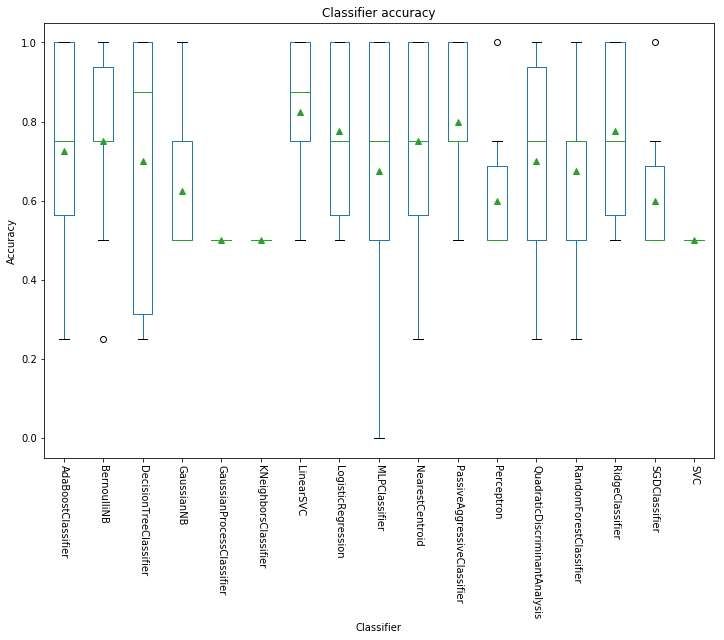

CPU times: user 3.91 s, sys: 33.3 ms, total: 3.95 s
Wall time: 2.51 s


In [50]:
%%time
# Now evaluate a bunch of classifiers
classifiers = [
    AdaBoostClassifier(),
    BernoulliNB(),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(),
    LinearSVC(),
    LogisticRegression(solver='lbfgs'),
    MLPClassifier(alpha=1), # Slow!
    NearestCentroid(),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    Perceptron(max_iter=1000, tol=1e-3),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RidgeClassifier(tol=1e-2, solver="lsqr"),
    SGDClassifier(max_iter=1000, tol=1e-3),
    SVC(gamma=2, C=1)
]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results = {}
    for classifier in classifiers:
        clf_name = classifier.__class__.__name__
        scores = cross_validate(classifier, X, y, cv=10, return_train_score=False)
        print(f"{clf_name} = {np.mean(scores['test_score'])}")
        results[clf_name] = scores

# Tabulate results
df = pd.DataFrame.from_dict(results, orient='index')
df['time'] = df.fit_time.apply(lambda x: np.mean(np.asarray(x)))
df['score'] = df.test_score.apply(lambda x: np.mean(np.asarray(x)))
df['std'] = df.test_score.apply(lambda x: np.std(np.asarray(x)))
display(df[['score', 'std', 'time']].sort_values(by='score', ascending=False))

# Plot results
pd.DataFrame(
    df['test_score'].values.tolist(), 
    index=df.index
).T.plot.box(
    figsize=(12,8), 
    rot=-90, 
    sort_columns=True,
    showmeans=True
)
plt.title("Classifier accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.show()